# Etap 1
## Wczytanie surowych danych, tłumaczenie nazw kolumn
## t-SNE


In [1]:
# run only once
#!pip install deep-translator

In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
from deep_translator import GoogleTranslator


In [3]:
# Ścieżka do folderu z plikami Excel
folder_path = "Data/Turkish Public Companies Balance Sheets from KAP"

# Lista wszystkich plików .xlsx w folderze
excel_files = glob(os.path.join(folder_path, "*.xlsx"))

# Weź tylko pierwsze 5 plików
excel_files = excel_files

# Lista do zebrania przetworzonych DataFrame'ów
df_list = []

for file in excel_files:
    # Wczytaj plik
    df = pd.read_excel(file)
    
    # Pivot: z długiego na szeroki format
    df_wide = df.pivot_table(index=[], columns='Desc', values='Yıllık', aggfunc='first').reset_index()

    # Dodaj kolumnę z nazwą pliku (bez ścieżki)
    df_wide['source_file'] = os.path.basename(file)
    
    # Dodaj do listy
    df_list.append(df_wide)

# Połącz wszystkie w jeden DataFrame
final_df = pd.concat(df_list, ignore_index=True)


final_df['Nazwa'] = final_df['source_file'].str.extract(r'^([^_]+)')[0]
final_df['Rok'] = final_df['source_file'].str.extract(r'_([0-9]{4})')[0]





In [4]:
# Tłumaczymy wszystkie kolumny
translated_columns = [GoogleTranslator(source='tr', target='pl').translate(col) for col in final_df.columns]

# Przypisujemy nowe kolumny
final_df.columns = translated_columns


# Wyświetl wynik
print("Przetłumaczone kolumny:")
len( translated_columns)
final_df.head()

Przetłumaczone kolumny:


,indeks,(SubTotal),Przepisy długoterminowe,Amortyzacja i straż pożarna,Kapitał partnerstwa głównego,Akcje mniejszościowe,Przepisy zadłużenia,Żywe istoty,Zachęta państwowa i pomoc,Zwiększenie wartości fundusze,...,Zobowiązania długoterminowe,Inne dochody i wydatki przed opodatkowaniem,Yab. Money Trans. Różnica. Efekt. Poprzedni.nak.ve nak. Tak jak. Wzrost/spadek netto,Sprzedaż zagraniczna,Sprzedaż krajowa,Akcje zysków/strat inwestycji cenianych metodą samowystarczalności,Samo -właściwość,Źródło_pliku,Nazwa,Rok
0,Yıllık,4.524640e+08,678404.0,1242248.0,1.387926e+08,0.0,2852756.0,0.0,0.0,0.0,...,2806817.0,449296.0,-9990337.0,0.0,0.0,0.0,1.387926e+08,A1CAP_2020.xlsx,A1CAP,2020
1,Yıllık,8.515088e+08,0.0,3263754.0,2.966258e+08,0.0,6670834.0,0.0,0.0,0.0,...,8695590.0,777230.0,121976765.0,0.0,0.0,0.0,2.966258e+08,A1CAP_2021.xlsx,A1CAP,2021
2,Yıllık,4.019261e+09,4748296.0,12651941.0,1.487849e+09,0.0,70752251.0,0.0,0.0,0.0,...,132279622.0,17107575.0,463136619.0,0.0,0.0,0.0,1.487849e+09,A1CAP_2022.xlsx,A1CAP,2022
3,Yıllık,6.297396e+09,7715324.0,21452328.0,3.696944e+09,0.0,42331251.0,0.0,0.0,0.0,...,34025698.0,6055765.0,691863980.0,0.0,0.0,0.0,3.696944e+09,A1CAP_2023.xlsx,A1CAP,2023
4,Yıllık,8.297508e+09,9773361.0,31826374.0,4.065838e+09,0.0,28062814.0,0.0,0.0,0.0,...,160295553.0,5169826.0,369461172.0,0.0,0.0,0.0,4.065838e+09,A1CAP_2024.xlsx,A1CAP,2024


In [5]:
q = 0.4

# Oblicz odsetek NaN w każdej kolumnie
nan_ratio = final_df.isna().mean()


# Wybierz kolumny do odrzucenia (mające więcej niż q NaN)
columns_to_drop = nan_ratio[nan_ratio > q].index


print("\n❌ Kolumny, które zostaną odrzucone (> {:.0%} NaN):".format(q))
print(list(columns_to_drop))
len(columns_to_drop)


❌ Kolumny, które zostaną odrzucone (> 40% NaN):
['Odkładane przychody (obietnica klienta. Dogan Load. Zewnętrzna. Kal.)', 'Odkładane przychody (Word Client Word.doğan Yür.', 'Prawo do używania aktywów', 'Obietnica klienta. Obciążenie Dogan.', 'Słowo klienta.', 'Aktywa wynikające z umów o klienta', 'Zysk/strata aktywności przed kosztem finansowania']


7

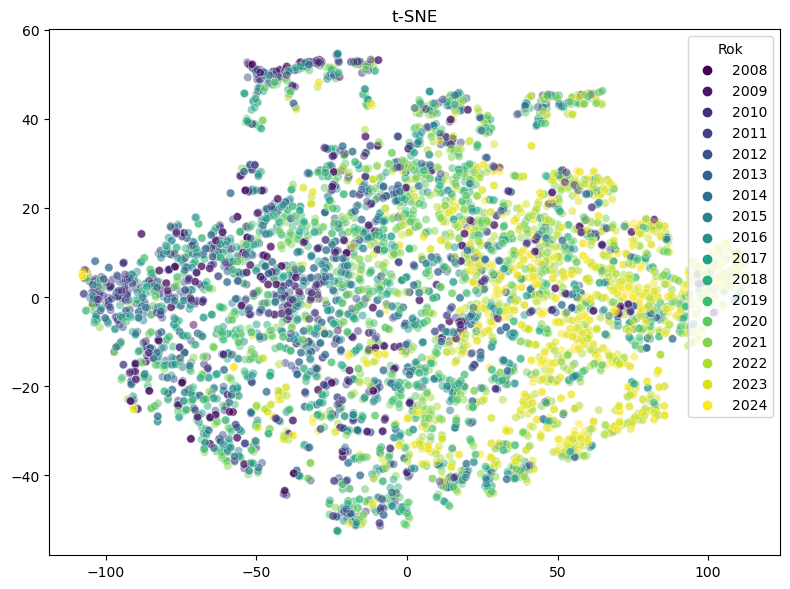

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Parametr: ile rekordów chcemy wyświetlić
n = 5700

# Losowy wybór n rekordów (jeśli mamy więcej niż n)
if len(final_df) > n:
    sampled_df = final_df.sample(n, random_state=42)
else:
    sampled_df = final_df.copy()

# 1. Przygotowanie danych: wybieramy tylko kolumny numeryczne i zamieniamy NaN na 0
X = sampled_df.select_dtypes(include=[np.number]).fillna(0)

# Upewnijmy się, że kolumna 'rocznie' jest typu liczbowego (int) i posortowana
sampled_df['Rok'] = pd.to_numeric(sampled_df['Rok'], errors='coerce')
sampled_df['Rok'] = sampled_df['Rok'].sort_values()

# 2. t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# 3. Wizualizacja
plt.figure(figsize=(8, 6))

# Scatter plot z legendą, uwzględniając porządek liczbowy
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sampled_df['Rok'], palette='viridis', legend='full',alpha=0.5 )

# Dodajemy tytuł
plt.title('t-SNE')

# Wyświetlamy legendę
plt.legend(title='Rok', loc='upper right')

plt.tight_layout()
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_3388\1333459296.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df_unique.loc[:, 'Rok'] = pd.to_numeric(sampled_df_unique['Rok'], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_3388\1333459296.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df_unique.loc[:, 'Rok'] = sampled_df_unique['Rok'].sort_values()


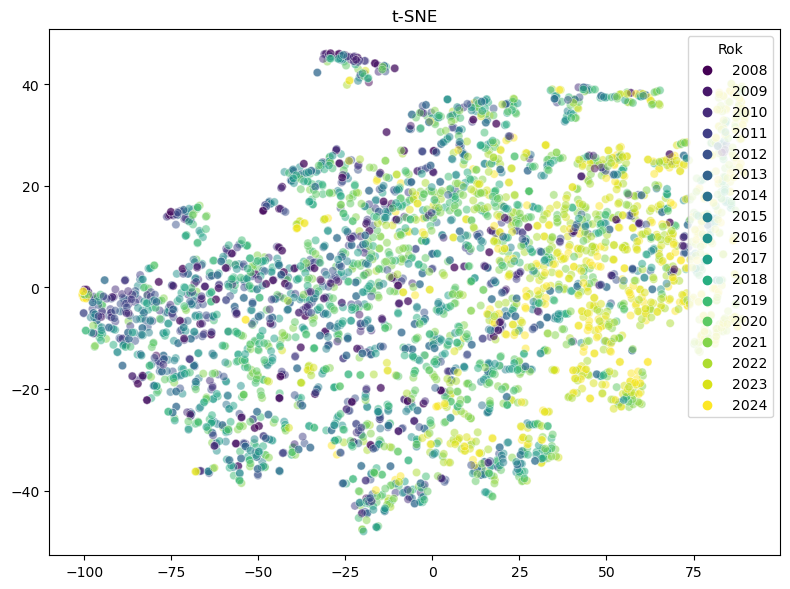

In [16]:
# Parametr: ile unikalnych nazw chcemy wybrać
N = 400  # Liczba unikalnych nazw

# Wybór N różnych nazw z kolumny 'nazwa' (lub jakiejkolwiek kolumny z unikalnymi wartościami)
unique_names = sampled_df['Nazwa'].drop_duplicates().sample(N, random_state=42)

# Filtrujemy rekordy, które odpowiadają wybranym nazwom
sampled_df_unique = sampled_df[sampled_df['Nazwa'].isin(unique_names)]

# 1. Przygotowanie danych: wybieramy tylko kolumny numeryczne i zamieniamy NaN na 0
X = sampled_df_unique.select_dtypes(include=[np.number]).fillna(0)

# Upewnijmy się, że kolumna 'rocznie' jest typu liczbowego (int) i posortowana
sampled_df_unique.loc[:, 'Rok'] = pd.to_numeric(sampled_df_unique['Rok'], errors='coerce')

# Posortuj wartości w kolumnie 'rocznie' (jeśli wymagane jest posortowanie)
sampled_df_unique.loc[:, 'Rok'] = sampled_df_unique['Rok'].sort_values()

# 2. t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# 3. Wizualizacja
plt.figure(figsize=(8, 6))

# Scatter plot z legendą, uwzględniając porządek liczbowy
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sampled_df_unique['Rok'], palette='viridis', legend='full',alpha=0.5 )

# Dodajemy tytuł
plt.title('t-SNE')

# Wyświetlamy legendę
plt.legend(title='Rok', loc='upper right')

plt.tight_layout()
plt.show()



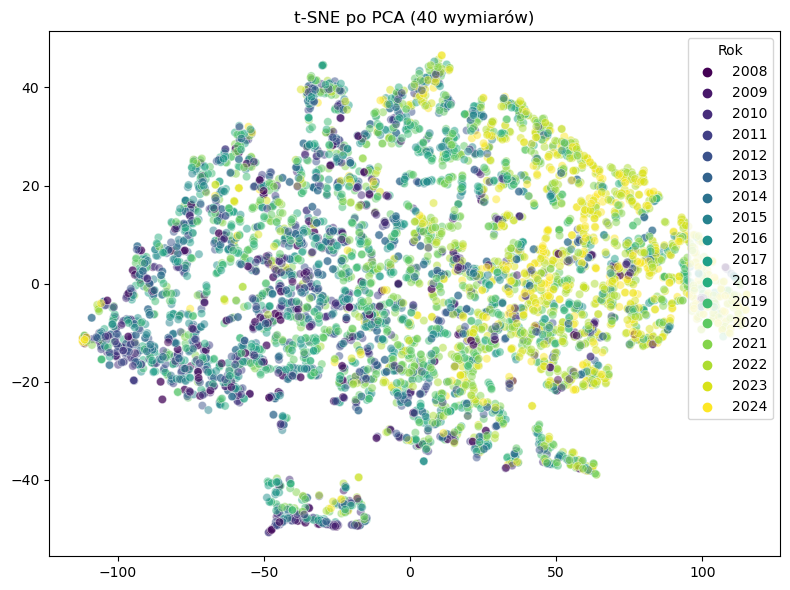

In [14]:
from sklearn.decomposition import PCA


# Parametr: ile rekordów chcemy wyświetlić
n = 5700

# Losowy wybór n rekordów (jeśli mamy więcej niż n)
if len(final_df) > n:
    sampled_df = final_df.sample(n, random_state=42)
else:
    sampled_df = final_df.copy()

# 1. Przygotowanie danych: wybieramy tylko kolumny numeryczne i zamieniamy NaN na 0
X = sampled_df.select_dtypes(include=[np.number]).fillna(0)

# 2. PCA redukcja do 40 wymiarów
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

# 3. t-SNE na danych po PCA
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# 4. Upewnijmy się, że kolumna 'Rok' jest liczbą i w dobrej kolejności
sampled_df['Rok'] = pd.to_numeric(sampled_df['Rok'], errors='coerce')

# 5. Wizualizacja
plt.figure(figsize=(8, 6))

# Scatter plot z legendą
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sampled_df['Rok'], palette='viridis', legend='full', alpha=0.5)

# Dodajemy tytuł
plt.title('t-SNE po PCA (40 wymiarów)')

# Legenda
plt.legend(title='Rok', loc='upper right')

plt.tight_layout()
plt.show()


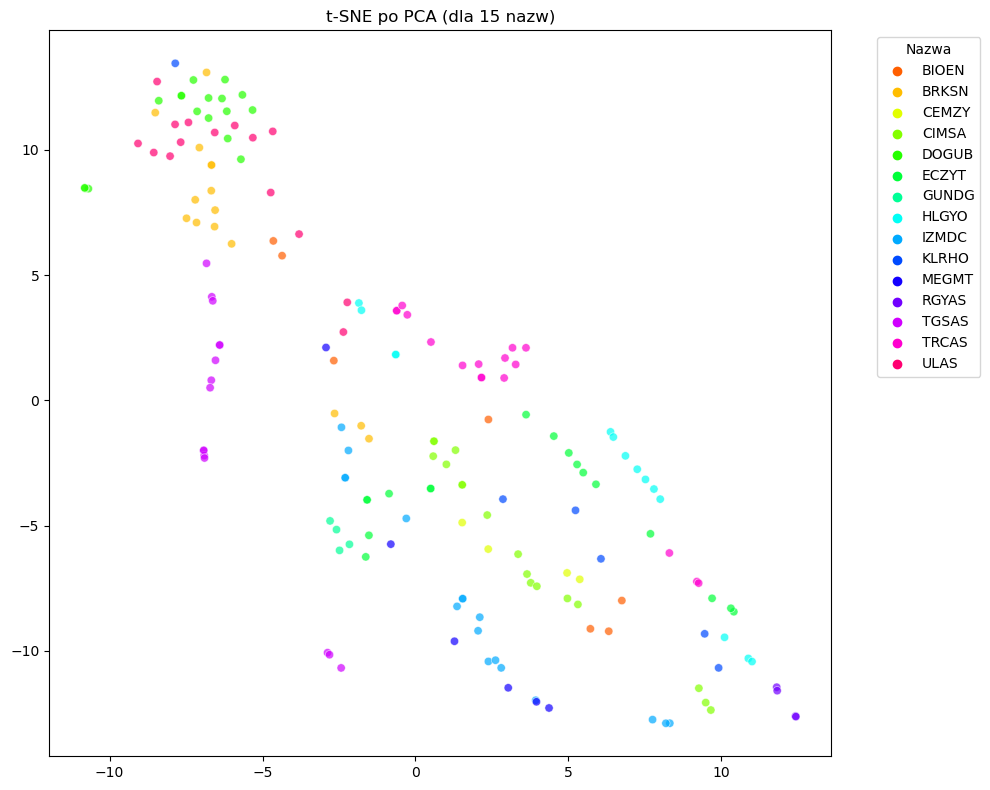

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Parametr: liczba unikalnych nazw do pokazania
N = 15  # <- tu ustawiasz ile chcesz

# 1. Wybieramy N unikalnych nazw
unique_names = final_df['Nazwa'].dropna().unique()
selected_names = np.random.choice(unique_names, size=min(N, len(unique_names)), replace=False)

# 2. Filtrowanie danych tylko do wybranych nazw
sampled_df = final_df[final_df['Nazwa'].isin(selected_names)].copy()

# 3. Przygotowanie danych: tylko numeryczne kolumny i NaN -> 0
X = sampled_df.select_dtypes(include=[np.number]).fillna(0)

# 4. PCA redukcja do 10 wymiarów
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

# 5. t-SNE na danych po PCA
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# 6. Przygotowujemy paletę kolorów dynamicznie
palette = sns.color_palette('hsv', n_colors=N)

# 7. Wizualizacja
plt.figure(figsize=(10, 8))

# Scatter plot z kolorami według 'Nazwa'
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sampled_df['Nazwa'], palette=palette, legend='full', alpha=0.7)

# Tytuł
plt.title(f't-SNE po PCA (dla {N} nazw)')

# Legenda
plt.legend(title='Nazwa', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [21]:
final_df.to_csv('by_year_features.csv', index=False, encoding='utf-8-sig')